In [1]:
from VR_Trajectory_analysis import *

In [2]:
directory = '/Users/apaula/ownCloud/MatrexVR1/20250226_BlueGreenBlue_Geometry_Data/RunData'

In [3]:
df = get_combined_df(directory, trim_seconds=1.0)

Processing subfolder: 20250312_155324
Processing subfolder: 20250311_165653
No data loaded from /Users/apaula/ownCloud/MatrexVR1/20250226_BlueGreenBlue_Geometry_Data/RunData/20250311_165653/20250311_165653_Choice_noBG_VR4_.csv
No data loaded from /Users/apaula/ownCloud/MatrexVR1/20250226_BlueGreenBlue_Geometry_Data/RunData/20250311_165653/20250311_165653_Forrest_choice_VR4_.csv
No data loaded from /Users/apaula/ownCloud/MatrexVR1/20250226_BlueGreenBlue_Geometry_Data/RunData/20250311_165653/20250311_165653_Forrest_choice_VR2_.csv
No data loaded from /Users/apaula/ownCloud/MatrexVR1/20250226_BlueGreenBlue_Geometry_Data/RunData/20250311_165653/20250311_165653_Choice_noBG_VR2_.csv
No data loaded from /Users/apaula/ownCloud/MatrexVR1/20250226_BlueGreenBlue_Geometry_Data/RunData/20250311_165653/20250311_165653_Choice_noBG_VR3_.csv
No data loaded from /Users/apaula/ownCloud/MatrexVR1/20250226_BlueGreenBlue_Geometry_Data/RunData/20250311_165653/20250311_165653_Forrest_choice_VR3_.csv
Processin

In [5]:
df["FlyID"].nunique()

63

In [6]:
df = add_trial_id_and_displacement(df)
df = add_trial_time(df)

In [7]:
df_stationary, df_normal, df_excessive, stationary_ids, normal_ids, excessive_ids = classify_trials_by_displacement(df[df['Scene']=='Choice_noBG'], min_disp=0, max_disp=500)

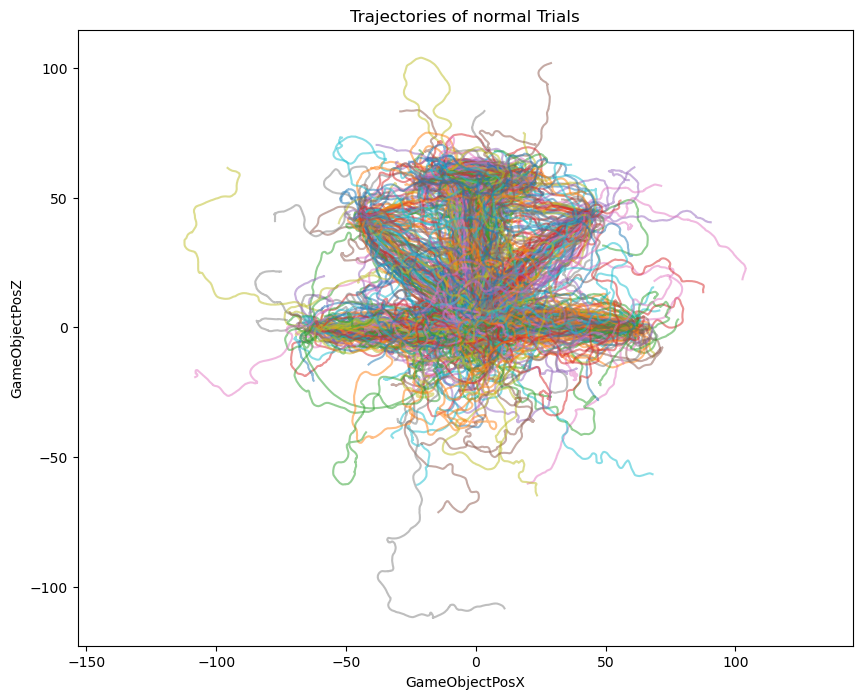

In [8]:
plot_trajectories(df_normal, 'normal')

In [9]:
import pandas as pd
import numpy as np

# 1. Define your different config groups and their corresponding goals
#    (You can rename these lists and add/remove as needed.)
configs_2_goals_front = [
    "BinaryChoice11_constantSize_BlackCylinder_BlackCylinder.json",
    "BinaryChoice_constantSize_BlueGreenCylinder_BlueCylinder.json",
    "BinaryChoice_constantSize_BlueCylinder_BlueGreenCylinder.json"
]

# For these configs, the left and right goals are at:
# (-10.416, 59.088) and (10.416, 59.088).
# Adjust threshold or other parameters as needed.
left_goal_1 = (-10.416, 59.088)
right_goal_1 = (10.416, 59.088)

# If you have other configs that use 2 goals with a different positioning:
configs_2_goals_side = [
    "BinaryChoice_constantSize_180deg_BlueGreenCylinder_BlueCylinder.json",
    "BinaryChoice_constantSize_180deg_BlueCylinder_BlueGreenCylinder.json"
]
left_goal_2 = (-60, 0)
right_goal_2 = (60, 0)

configs_2_goals_diag = [
    "BinaryChoice_constantSize_90deg_BlueCylinder_BlueGreenCylinder.json",
    "BinaryChoice_constantSize_90deg_BlueGreenCylinder_BlueCylinder.json"
]
left_goal_3 = (-42.43, 42.43)
right_goal_3 = (42.43, 42.43)

# For 3-goal configs:
configs_3_goals = [
    "3Cylinders111_constantSize.json"
]
triple_center_goal = (0, 60)
triple_left_goal = (-20.5212, 56.381557)
triple_right_goal = (20.5212, 56.381557)

# For single-goal configs (if needed):
configs_center_only = [
]
center_goal = (0, 60)


# 2. Subset your df_normal by each group and call get_first_goal_reached
def get_first_goal_reached(
    df_normal,
    goals,            # A list of (goal_name, (x, z)) tuples
    threshold=3.5
):
    """
    Given a dataframe of trial data, determine the first goal reached 
    and the time at which it was reached for each UniqueTrialID.
    
    Parameters
    ----------
    df_normal : pd.DataFrame
        The dataframe containing trial data. Must contain columns:
        ['UniqueTrialID', 'ConfigFile', 'trial_time', 'GameObjectPosX', 'GameObjectPosZ'].
    goals : list of (str, (float, float))
        A list of (goal_name, (x, z)) to check.
    threshold : float, optional
        Distance threshold below which a goal is considered reached.

    Returns
    -------
    pd.DataFrame
        A dataframe with one row per UniqueTrialID, including:
        ['UniqueTrialID', 'ConfigFile', 'FirstReachedGoal', 'GoalReachedTime'].
    """
    
    def distance(p1, p2):
        return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)
    
    results = []
    
    # Group by UniqueTrialID
    for trial_id, trial_data in df_normal.groupby('UniqueTrialID'):
        config = trial_data['ConfigFile'].iloc[0]
        
        # Sort by time
        trial_data = trial_data.sort_values(by='trial_time')
        
        first_reached = None
        reached_time = None
        
        for idx, row in trial_data.iterrows():
            participant_pos = (row['GameObjectPosX'], row['GameObjectPosZ'])
            
            # Check each goal
            for goal_name, goal_pos in goals:
                if distance(participant_pos, goal_pos) <= threshold:
                    first_reached = goal_name
                    reached_time = row['trial_time']
                    break
            
            if first_reached is not None:
                break
        
        results.append((trial_id, config, first_reached, reached_time))
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results, columns=[
        'UniqueTrialID',
        'ConfigFile',
        'FirstReachedGoal',
        'GoalReachedTime'
    ])
    
    return results_df


# 3. Filter and run for each group, then concatenate

# --- Group 1: 2 goals (front) ---
df_2_goals_front = df_normal[df_normal['ConfigFile'].isin(configs_2_goals_front)].copy()
results_2_goals_front = get_first_goal_reached(
    df_2_goals_front,
    goals=[
        ('left', left_goal_1),
        ('right', right_goal_1)
    ],
    threshold=3.5
)

# --- Group 2: 2 goals (left=-60,0 ; right=60,0) ---
df_2_goals_side = df_normal[df_normal['ConfigFile'].isin(configs_2_goals_side)].copy()
results_2_goals_side = get_first_goal_reached(
    df_2_goals_side,
    goals=[
        ('left', left_goal_2),
        ('right', right_goal_2)
    ],
    threshold=3.5
)

# --- Group 3: 2 goals (diagonal) ---
df_2_goals_diag = df_normal[df_normal['ConfigFile'].isin(configs_2_goals_diag)].copy()
results_2_goals_diag = get_first_goal_reached(
    df_2_goals_diag,
    goals=[
        ('left', left_goal_3),
        ('right', right_goal_3)
    ],
    threshold=3.5
)

# --- Group 4: 3 goals ---
df_3_goals = df_normal[df_normal['ConfigFile'].isin(configs_3_goals)].copy()
results_3_goals = get_first_goal_reached(
    df_3_goals,
    goals=[
        ('triple_center', triple_center_goal),
        ('triple_left', triple_left_goal),
        ('triple_right', triple_right_goal)
    ],
    threshold=3.5
)

# --- Group 5: single center goal (if needed) ---
df_center_only = df_normal[df_normal['ConfigFile'].isin(configs_center_only)].copy()
results_center_only = get_first_goal_reached(
    df_center_only,
    goals=[('center', center_goal)],
    threshold=3.5
)

# 4. Concatenate all results
all_results = pd.concat([
    results_2_goals_front,
    results_2_goals_side,
    results_2_goals_diag,
    results_3_goals,
    results_center_only
], ignore_index=True)

# all_results now contains the first reached goal for each UniqueTrialID
# from each different config group.


In [10]:
df['ConfigFile'].unique()

array(['BinaryChoice_constantSize_BlueGreenCylinder_BlueCylinder.json',
       'BinaryChoice_constantSize_180deg_BlueGreenCylinder_BlueCylinder.json',
       'BinaryChoice11_constantSize_BlackCylinder_BlackCylinder.json',
       'BinaryChoice_constantSize_BlueCylinder_BlueGreenCylinder.json',
       '3Cylinders111_constantSize.json',
       'BinaryChoice_constantSize_90deg_BlueGreenCylinder_BlueCylinder.json',
       'BinaryChoice_constantSize_90deg_BlueCylinder_BlueGreenCylinder.json',
       'BinaryChoice_constantSize_180deg_BlueCylinder_BlueGreenCylinder.json',
       'Treecircle.json'], dtype=object)

In [11]:
all_results.to_pickle("geometry2_results_df.pkl")

In [12]:
results_df = pd.read_pickle("geometry2_results_df.pkl")

In [13]:
results_df['FirstReachedGoal'].unique()

array([None, 'left', 'right', 'triple_left', 'triple_center',
       'triple_right'], dtype=object)

In [14]:
# 1. Keep only trials that actually reached a goal
valid_results = results_df.dropna(subset=['FirstReachedGoal'])

# 2. Merge the cutoff times back into df
#    We merge on 'UniqueTrialID' to get each trial's GoalReachedTime.
df_merged = pd.merge(df, valid_results[['UniqueTrialID', 'GoalReachedTime', 'FirstReachedGoal']], on='UniqueTrialID', how='inner')

# 3. Filter df so that only rows with trial_time less than or equal to the goal time are kept
df_cut = df_merged[df_merged['trial_time'] <= df_merged['GoalReachedTime']]

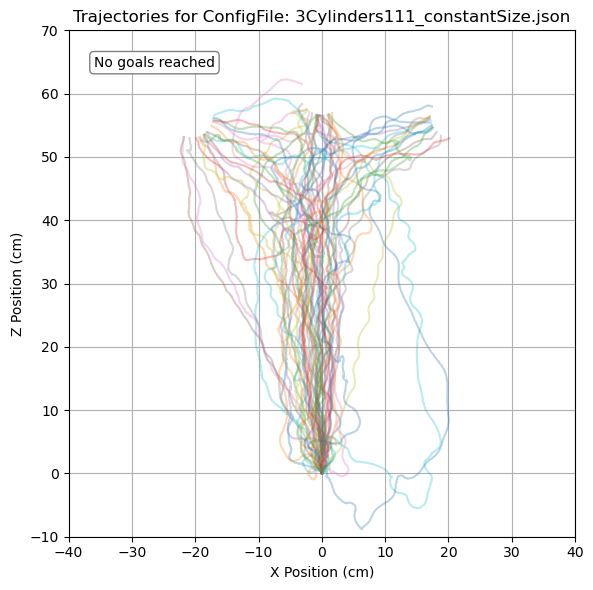

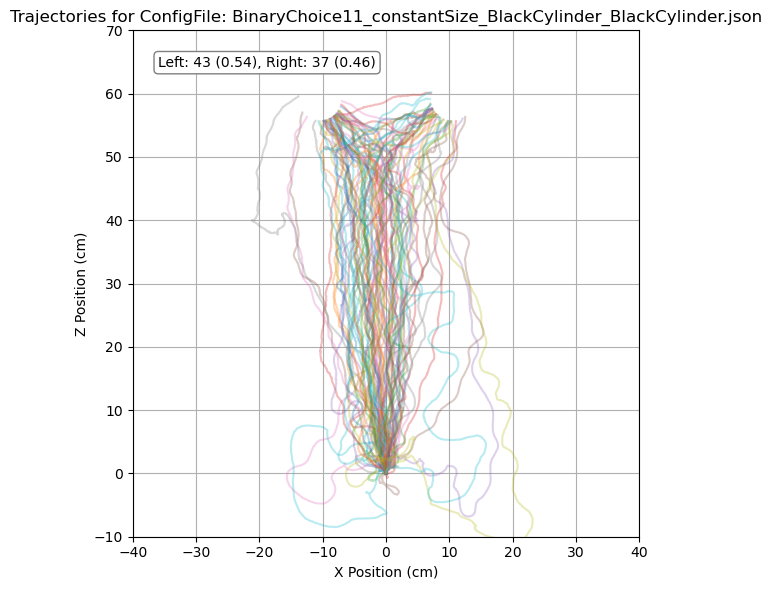

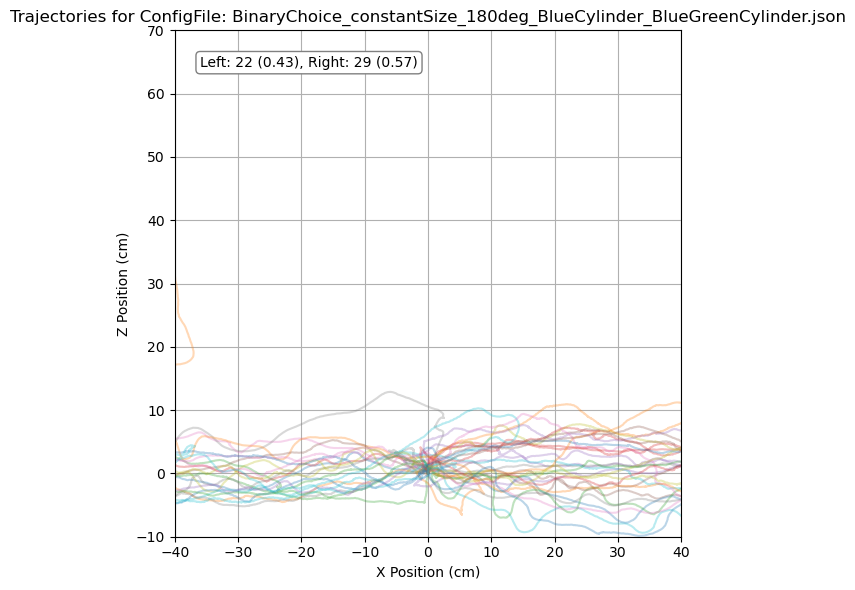

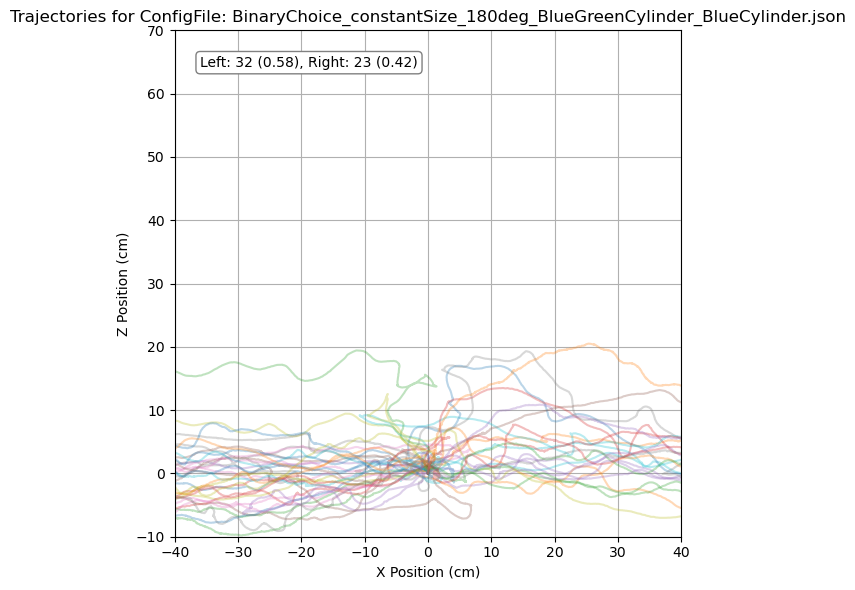

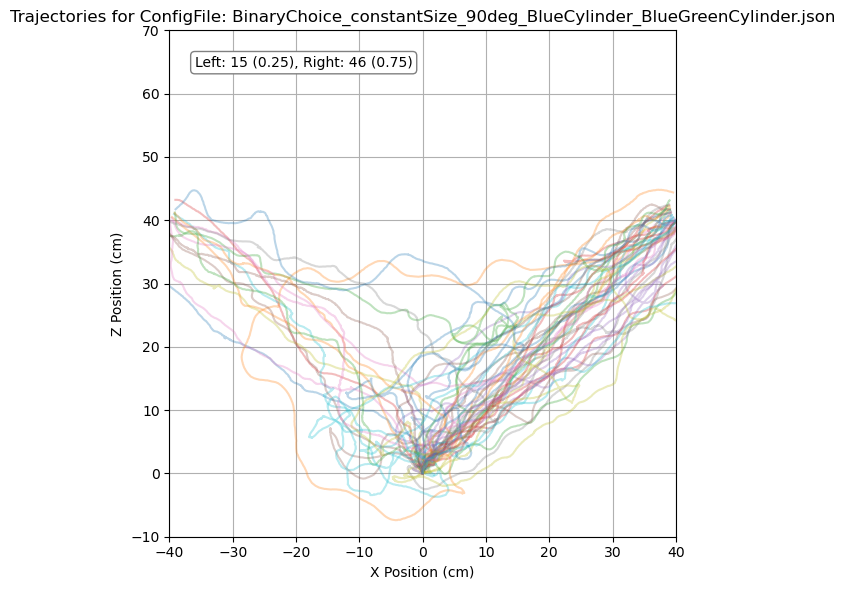

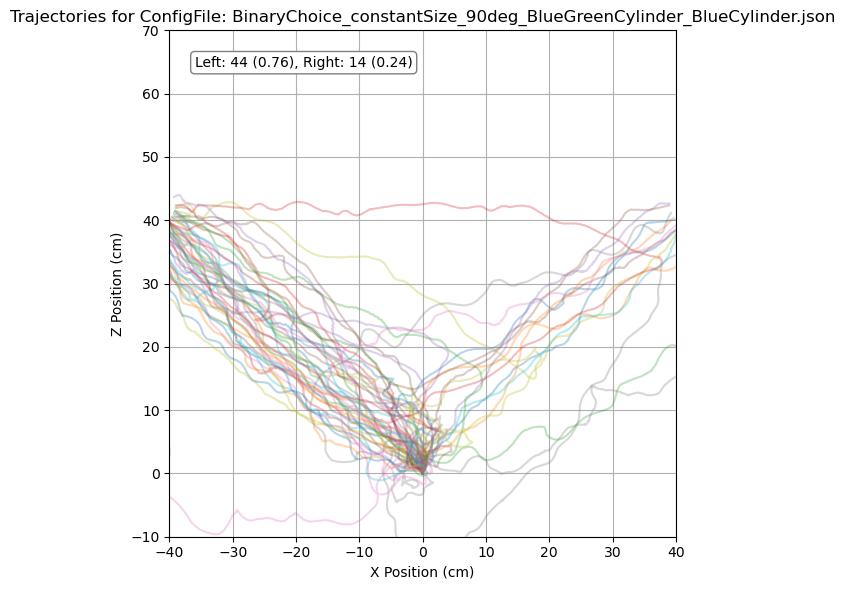

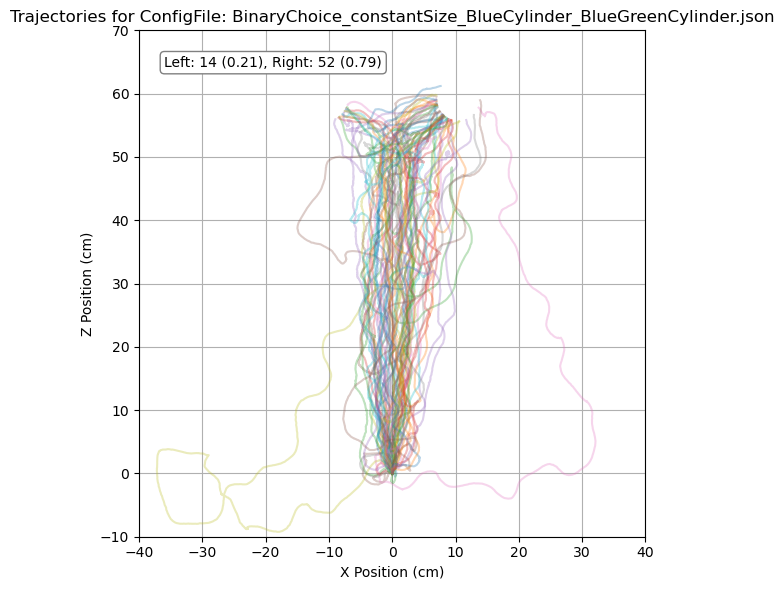

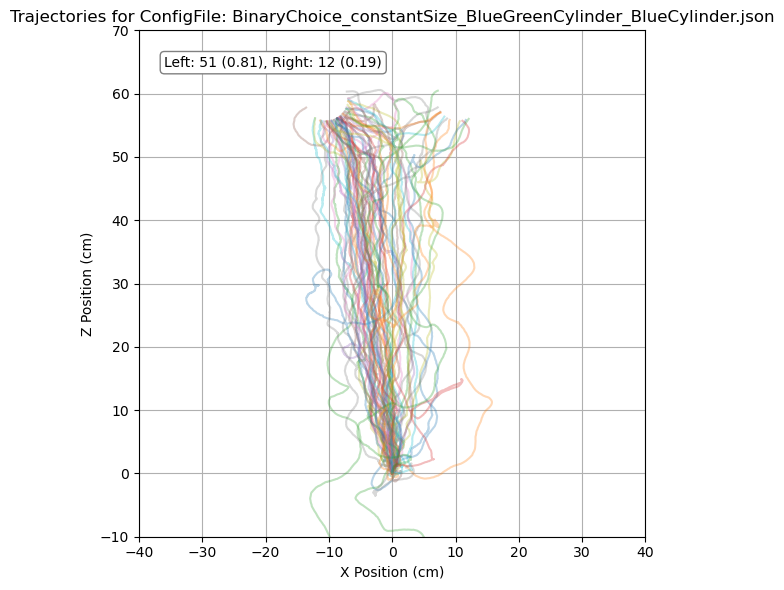

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Assume these from previous steps:
center_only_configs = [
    "BinaryChoice10_BlackCylinder_control.json",
    "BinaryChoice10_constantSize_BlackCylinder_control.json"
]

# Identify which ConfigFiles have multiple goals
# Since we know only the two listed above are single-goal configs,
# all others are multi-goal configs.
all_configs = df_cut['ConfigFile'].unique()
multi_goal_configs = [c for c in all_configs if c not in center_only_configs]

# Merge results_df to get the goal reached information into df_cut if needed
# (Not strictly necessary if we only need ratios. We can just use results_df separately.)
# But let's have a convenient DataFrame for ratio calculations.
df_joined = pd.merge(df_cut, results_df[['UniqueTrialID', 'FirstReachedGoal']], on='UniqueTrialID', how='left')

# Group the truncated data by ConfigFile
for config, group in df_joined.groupby('ConfigFile'):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot each trial’s trajectory
    for trial_id, trial_data in group.groupby('UniqueTrialID'):
        ax.plot(trial_data['GameObjectPosX'], trial_data['GameObjectPosZ'], alpha=0.3)
    
    ax.set_ylim(-10, 70)
    ax.set_xlim(-40, 40)
    
    # Make axes equal
    ax.set_aspect('equal', adjustable='box')

    # Set plot titles and labels
    ax.set_title(f"Trajectories for ConfigFile: {config}")
    ax.set_xlabel("X Position (cm)")
    ax.set_ylabel("Z Position (cm)")
    ax.grid(True)
    
    # If it's a multi-goal config, calculate ratio left/right
    if config in multi_goal_configs:
        # Filter the trials for this config in results_df
        config_results = results_df.loc[results_df['UniqueTrialID'].isin(group['UniqueTrialID'].unique())]
        
        # Count how many reached left vs right
        left_count = (config_results['FirstReachedGoal'] == 'left').sum()
        right_count = (config_results['FirstReachedGoal'] == 'right').sum()
        
        # Compute ratio (e.g., left/total and right/total)
        total = left_count + right_count
        if total > 0:
            left_ratio = left_count / total
            right_ratio = right_count / total
            ratio_text = f"Left: {left_count} ({left_ratio:.2f}), Right: {right_count} ({right_ratio:.2f})"
        else:
            ratio_text = "No goals reached"
        
        # Add text box with ratio information
        ax.text(0.05, 0.95, ratio_text, transform=ax.transAxes, va='top', bbox=dict(boxstyle="round", fc="w", ec="0.5"))
    
    elif config in center_only_configs:
        # Filter the trials for this config in results_df
        config_results = results_df.loc[results_df['UniqueTrialID'].isin(group['UniqueTrialID'].unique())]
        
        # Count how many reached left vs right
        count = (config_results['FirstReachedGoal'] == 'center').sum()
        # Only center goal, no ratio needed
        ax.text(0.05, 0.95, f"Center goal only: {count}", transform=ax.transAxes, va='top', bbox=dict(boxstyle="round", fc="w", ec="0.5"))
    
    
    output_dir = '/Users/apaula/Downloads'
    # Remove '.json' from config filename and prepend 'trajectories_'
    base_name = os.path.splitext(config)[0]
    filename = f"trajectories4_{base_name}.png"
    filepath = os.path.join(output_dir, filename)
    
    # Save the figure
    fig.savefig(filepath, dpi=300)

    plt.tight_layout()
    plt.show()

In [16]:
df_cut

,Current Time,VR,Scene,CurrentSequenceScene,ConfigFile,CurrentTrial,CurrentStep,GameObjectPosX,GameObjectPosY,GameObjectPosZ,...,FlyID,UniqueTrialID,delta_x,delta_y,delta_z,step_distance,TotalDisplacement,trial_time,GoalReachedTime,FirstReachedGoal
0,2025-03-05 10:13:12.370,VR1,Choice_noBG,Choice_noBG,BinaryChoice_constantSize_BlueGreenCylinder_Bl...,0,25,-0.008285,0.0,0.026803,...,326,655,NaN,NaN,NaN,0.000000,126.970179,0.000,26.267,left
1,2025-03-05 10:13:12.386,VR1,Choice_noBG,Choice_noBG,BinaryChoice_constantSize_BlueGreenCylinder_Bl...,0,25,0.009066,0.0,0.061640,...,326,655,0.017351,0.0,0.034837,0.038919,126.970179,0.016,26.267,left
2,2025-03-05 10:13:12.403,VR1,Choice_noBG,Choice_noBG,BinaryChoice_constantSize_BlueGreenCylinder_Bl...,0,25,0.004095,0.0,0.135885,...,326,655,-0.004971,0.0,0.074245,0.074411,126.970179,0.033,26.267,left
3,2025-03-05 10:13:12.419,VR1,Choice_noBG,Choice_noBG,BinaryChoice_constantSize_BlueGreenCylinder_Bl...,0,25,0.038444,0.0,0.169081,...,326,655,0.034349,0.0,0.033196,0.047769,126.970179,0.049,26.267,left
4,2025-03-05 10:13:12.436,VR1,Choice_noBG,Choice_noBG,BinaryChoice_constantSize_BlueGreenCylinder_Bl...,0,25,0.049264,0.0,0.217492,...,326,655,0.010820,0.0,0.048411,0.049605,126.970179,0.066,26.267,left
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1279685,2025-03-17 16:37:11.979,VR4,Choice_noBG,Choice_noBG,BinaryChoice_constantSize_BlueGreenCylinder_Bl...,0,111,11.889820,0.0,55.759220,...,358,9128,0.032290,0.0,0.077560,0.084013,174.455857,27.087,27.154,right
1279686,2025-03-17 16:37:11.995,VR4,Choice_noBG,Choice_noBG,BinaryChoice_constantSize_BlueGreenCylinder_Bl...,0,111,11.948010,0.0,55.842920,...,358,9128,0.058190,0.0,0.083700,0.101940,174.455857,27.103,27.154,right
1279687,2025-03-17 16:37:12.012,VR4,Choice_noBG,Choice_noBG,BinaryChoice_constantSize_BlueGreenCylinder_Bl...,0,111,11.948010,0.0,55.842920,...,358,9128,0.000000,0.0,0.000000,0.000000,174.455857,27.120,27.154,right
1279688,2025-03-17 16:37:12.029,VR4,Choice_noBG,Choice_noBG,BinaryChoice_constantSize_BlueGreenCylinder_Bl...,0,111,11.996830,0.0,55.937270,...,358,9128,0.048820,0.0,0.094350,0.106232,174.455857,27.137,27.154,right


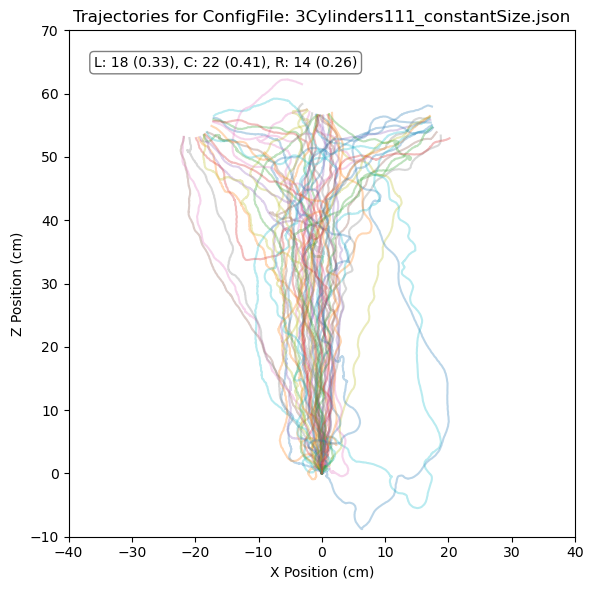

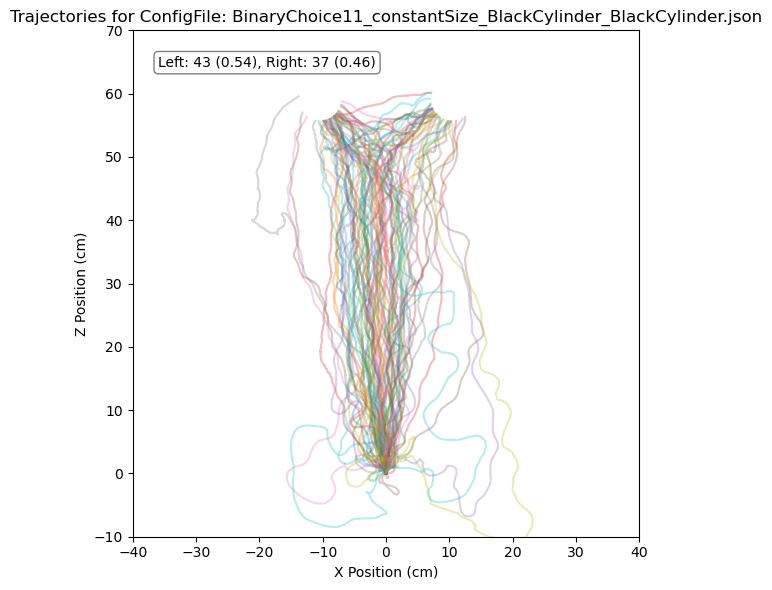

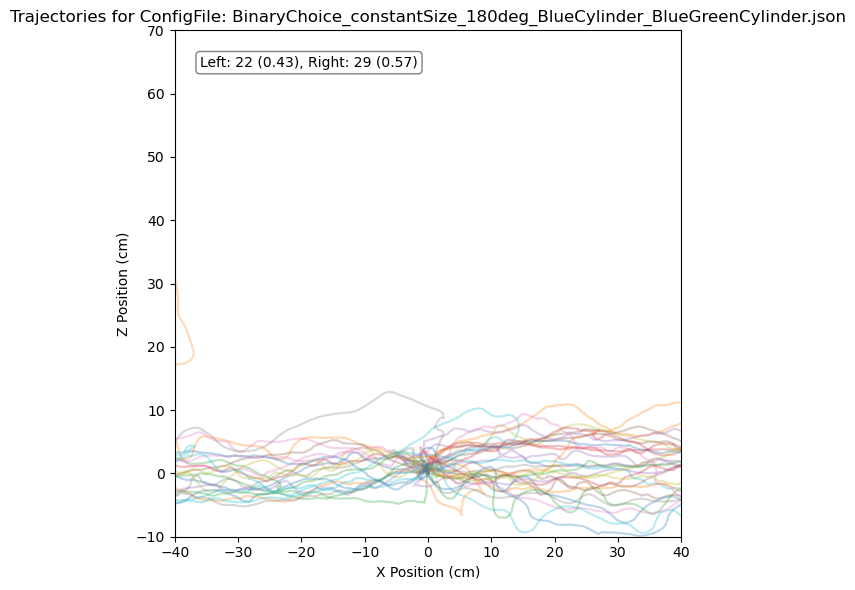

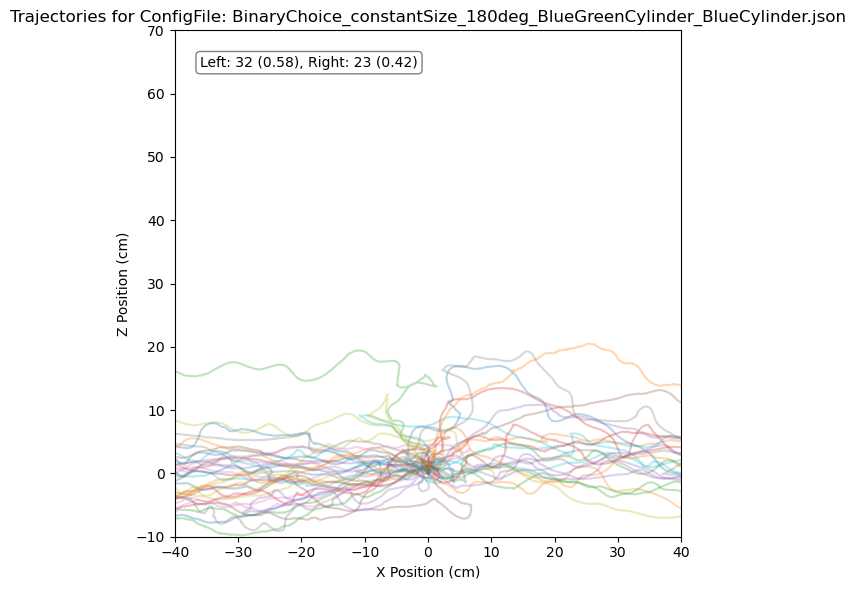

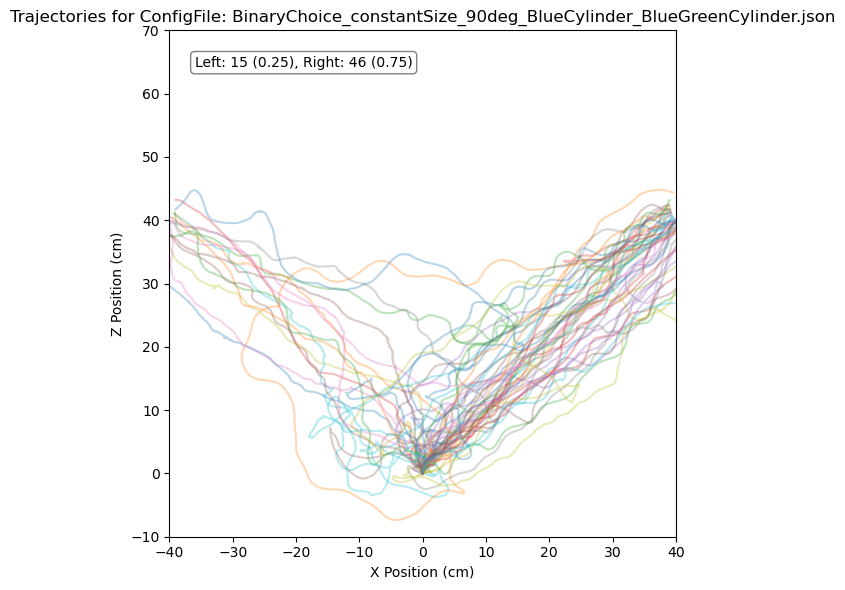

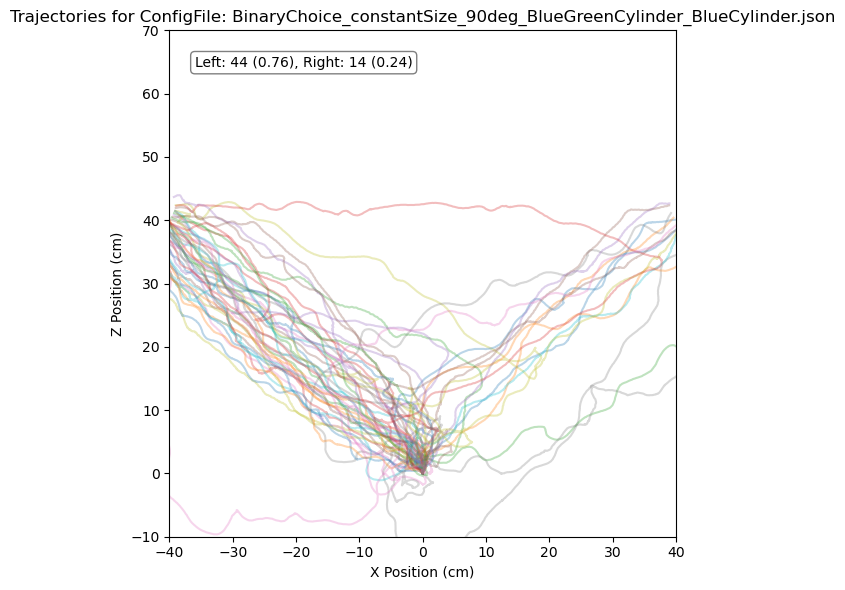

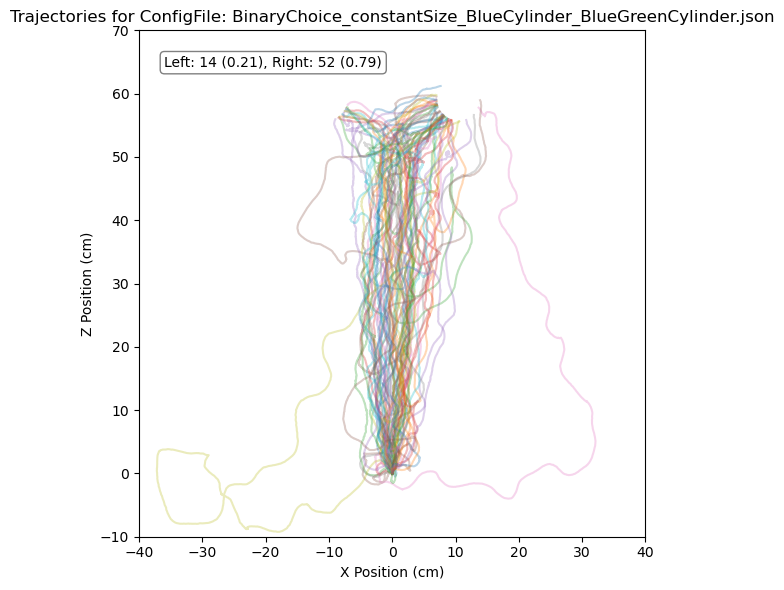

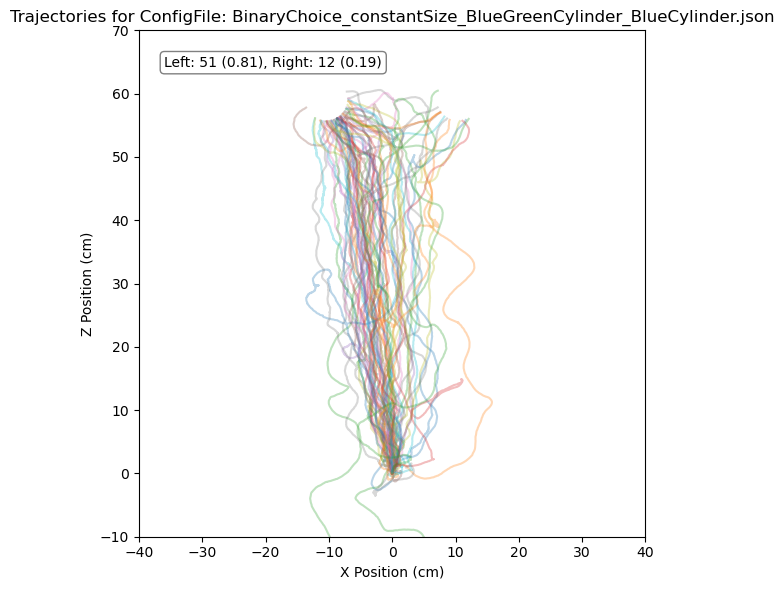

In [ ]:
# Identify which ConfigFiles have multiple goals or triple goals
all_configs = df_cut['ConfigFile'].unique()
configs_2_goals = [
    "BinaryChoice_constantSize_GreenCylinder_GreenCylinder.json",
    "BinaryChoice11_constantSize_BlackCylinder_BlackCylinder.json",
    "BinaryChoice_constantSize_BlueGreenCylinder_BlueCylinder.json",
    "BinaryChoice_constantSize_BlueCylinder_BlueGreenCylinder.json",
    "BinaryChoice_constantSize_180deg_BlueGreenCylinder_BlueCylinder.json",
    "BinaryChoice_constantSize_180deg_BlueCylinder_BlueGreenCylinder.json",
    "BinaryChoice_constantSize_90deg_BlueCylinder_BlueGreenCylinder.json",
    "BinaryChoice_constantSize_90deg_BlueGreenCylinder_BlueCylinder.json"
]

# Merge results_df to get the goal reached information into df_cut (if needed)
df_joined = pd.merge(
    df_cut, 
    results_df[['UniqueTrialID', 'FirstReachedGoal']], 
    on='UniqueTrialID', 
    how='left'
)

output_dir = '/Users/apaula/Downloads'

# Group the truncated data by ConfigFile
for config, group in df_joined.groupby('ConfigFile'):
    
    # --- 1. Plot all trajectories for this config ---
    fig, ax = plt.subplots(figsize=(8, 6))
    
    for trial_id, trial_data in group.groupby('UniqueTrialID'):
        ax.plot(trial_data['GameObjectPosX'], trial_data['GameObjectPosZ'], alpha=0.3)
    
    # Basic plot settings
    ax.set_ylim(-10, 70)
    ax.set_xlim(-40, 40)
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(f"Trajectories for ConfigFile: {config}")
    ax.set_xlabel("X Position (cm)")
    ax.set_ylabel("Z Position (cm)")
    ax.grid(False)
    
    # --- 2. Compute how many times each goal was reached for this config ---
    # Filter the relevant trials from results_df
    config_results = results_df.loc[results_df['UniqueTrialID'].isin(group['UniqueTrialID'].unique())]

    # 2a. Single center-goal configs
    if config in center_only_configs:
        center_count = (config_results['FirstReachedGoal'] == 'center').sum()
        ratio_text = f"Center goal only: {center_count}"
        ax.text(0.05, 0.95, ratio_text, transform=ax.transAxes, va='top',
                bbox=dict(boxstyle="round", fc="w", ec="0.5"))

    # 2b. Triple-goal configs
    elif config in configs_3_goals:
        # Count how many reached each of the three possible goals
        left_count = (config_results['FirstReachedGoal'] == 'triple_left').sum()
        center_count = (config_results['FirstReachedGoal'] == 'triple_center').sum()
        right_count = (config_results['FirstReachedGoal'] == 'triple_right').sum()
        
        total = left_count + center_count + right_count
        if total > 0:
            left_ratio = left_count / total
            center_ratio = center_count / total
            right_ratio = right_count / total
            ratio_text = (
                f"L: {left_count} ({left_ratio:.2f}), "
                f"C: {center_count} ({center_ratio:.2f}), "
                f"R: {right_count} ({right_ratio:.2f})"
            )
        else:
            ratio_text = "No goals reached"
        
        ax.text(0.05, 0.95, ratio_text, transform=ax.transAxes, va='top',
                bbox=dict(boxstyle="round", fc="w", ec="0.5"))

    # 2c. Two-goal configs (assume everything else with multiple goals is two-goal)
    elif config in configs_2_goals:
        left_count = (config_results['FirstReachedGoal'] == 'left').sum()
        right_count = (config_results['FirstReachedGoal'] == 'right').sum()
        
        total = left_count + right_count
        if total > 0:
            left_ratio = left_count / total
            right_ratio = right_count / total
            ratio_text = f"Left: {left_count} ({left_ratio:.2f}), Right: {right_count} ({right_ratio:.2f})"
        else:
            ratio_text = "No goals reached"
        
        ax.text(0.05, 0.95, ratio_text, transform=ax.transAxes, va='top',
                bbox=dict(boxstyle="round", fc="w", ec="0.5"))
    
    # 2d. If you have other special cases or an 'else' fallback:
    else:
        # If you have some unclassified configs
        ratio_text = "Unclassified Config"
        ax.text(0.05, 0.95, ratio_text, transform=ax.transAxes, va='top',
                bbox=dict(boxstyle="round", fc="w", ec="0.5"))

    # --- 3. Save and show the figure ---
    base_name = os.path.splitext(config)[0]
    filename = f"trajectories4_{base_name}.png"
    filepath = os.path.join(output_dir, filename)
    fig.savefig(filepath, dpi=300)
    
    plt.tight_layout()
    plt.show()

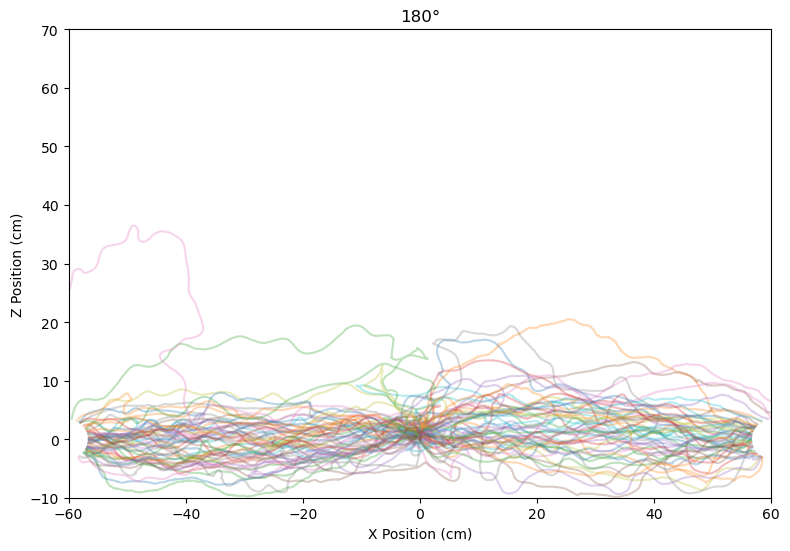

In [18]:
import matplotlib.pyplot as plt

# Choose the two configs to plot together
configs_to_plot = [
    "BinaryChoice_constantSize_180deg_BlueGreenCylinder_BlueCylinder.json",
    "BinaryChoice_constantSize_180deg_BlueCylinder_BlueGreenCylinder.json"
]

# Filter the merged DataFrame to these configs only
subset = df_joined[df_joined['ConfigFile'].isin(configs_to_plot)]

# Create a single figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Loop over each config and plot its trials
for idx, config in enumerate(configs_to_plot):
    group = subset[subset['ConfigFile'] == config]
    
    # Plot all trials for this config
    for trial_id, trial_data in group.groupby('UniqueTrialID'):
        ax.plot(trial_data['GameObjectPosX'], trial_data['GameObjectPosZ'], alpha=0.3)

    

# Basic plot settings
ax.set_xlim(-60, 60)
ax.set_ylim(-10, 70)
ax.set_aspect('equal', adjustable='box')
ax.set_title("180°")
ax.set_xlabel("X Position (cm)")
ax.set_ylabel("Z Position (cm)")
ax.grid(False)

plt.tight_layout()
plt.show()


In [19]:
df_cut.columns

Index(['Current Time', 'VR', 'Scene', 'CurrentSequenceScene', 'ConfigFile',
       'CurrentTrial', 'CurrentStep', 'GameObjectPosX', 'GameObjectPosY',
       'GameObjectPosZ', 'GameObjectRotX', 'GameObjectRotY', 'GameObjectRotZ',
       'SensPosX', 'SensPosY', 'SensPosZ', 'SensRotX', 'SensRotY', 'SensRotZ',
       'SourceFile', 'elapsed_time', 'ExperimenterName', 'Comments', 'FlyID',
       'UniqueTrialID', 'delta_x', 'delta_y', 'delta_z', 'step_distance',
       'TotalDisplacement', 'trial_time', 'GoalReachedTime',
       'FirstReachedGoal'],
      dtype='object')

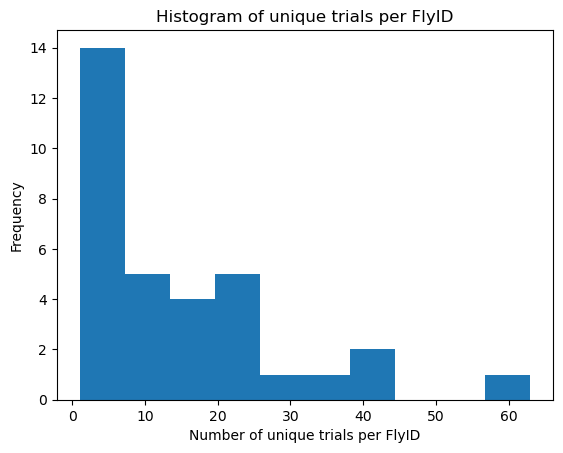

In [20]:
# Group by FlyID and count how many unique UniqueTrialID values each FlyID has
counts_per_fly = df_cut.groupby('FlyID')['UniqueTrialID'].nunique()

# View this as a histogram of how many trials each FlyID had
plt.hist(counts_per_fly)
plt.xlabel("Number of unique trials per FlyID")
plt.ylabel("Frequency")
plt.title("Histogram of unique trials per FlyID")
plt.show()

In [21]:
df_joined = pd.merge(df_cut, results_df[['UniqueTrialID', 'FirstReachedGoal']], on='UniqueTrialID', how='left')

import os
import matplotlib.pyplot as plt
import pandas as pd

# Specify which config you want to plot
config_of_interest = "BinaryChoice11_constantSize_15deg_10deg.json"

# Subset df_joined to only the config of interest
df_config = df_joined[df_joined["ConfigFile"] == config_of_interest].copy()

# Check if it's a multi-goal config or a center-only config
is_multi_goal = config_of_interest not in center_only_configs

# Create an output directory if needed
output_dir = '/Users/apaula/Downloads/sizebias'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Group by FlyID
for fly_id, group_fly in df_config.groupby('FlyID'):
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot each trial’s trajectory for this FlyID
    for trial_id, trial_data in group_fly.groupby('UniqueTrialID'):
        ax.plot(trial_data['GameObjectPosX'], trial_data['GameObjectPosZ'], alpha=0.3)

    # Set axis limits (adjust as needed)
    ax.set_ylim(-10, 70)
    ax.set_xlim(-40, 40)
    
    # Make axes equal
    ax.set_aspect('equal', adjustable='box')

    # Title and labels
    ax.set_title(f"Trajectories for ConfigFile: {config_of_interest}\nFlyID: {fly_id}")
    ax.set_xlabel("X Position (cm)")
    ax.set_ylabel("Z Position (cm)")
    ax.grid(True)

    # -----------------------------------------------------------
    # If it's a multi-goal config, calculate ratio left/right
    # -----------------------------------------------------------
    if is_multi_goal:
        # Filter the trials for this FlyID in results_df
        fly_results = results_df.loc[results_df['UniqueTrialID'].isin(group_fly['UniqueTrialID'].unique())]
        
        # Count how many reached left vs right
        left_count = (fly_results['FirstReachedGoal'] == 'left').sum()
        right_count = (fly_results['FirstReachedGoal'] == 'right').sum()
        
        # Compute ratio (e.g., left/total and right/total)
        total = left_count + right_count
        if total > 0:
            left_ratio = left_count / total
            right_ratio = right_count / total
            ratio_text = f"Left: {left_count} ({left_ratio:.2f}), Right: {right_count} ({right_ratio:.2f})"
        else:
            ratio_text = "No goals reached"
        
        # Add text box with ratio information
        ax.text(
            0.05, 0.95, ratio_text, 
            transform=ax.transAxes, va='top', 
            bbox=dict(boxstyle="round", fc="w", ec="0.5")
        )
    
    # -----------------------------------------------------------
    # If it's a single (center) goal config
    # -----------------------------------------------------------
    else:
        # Filter the trials for this FlyID in results_df
        fly_results = results_df.loc[results_df['UniqueTrialID'].isin(group_fly['UniqueTrialID'].unique())]
        
        # Count how many reached 'center'
        center_count = (fly_results['FirstReachedGoal'] == 'center').sum()
        
        ax.text(
            0.05, 0.95, f"Center goal only: {center_count}", 
            transform=ax.transAxes, va='top',
            bbox=dict(boxstyle="round", fc="w", ec="0.5")
        )
    
    # -----------------------------------------------------------
    # Save and show
    # -----------------------------------------------------------
    base_name = os.path.splitext(config_of_interest)[0]
    filename = f"trajectories_{base_name}_FlyID_{fly_id}.png"
    filepath = os.path.join(output_dir, filename)
    fig.savefig(filepath, dpi=300)

    plt.tight_layout()
    plt.show()

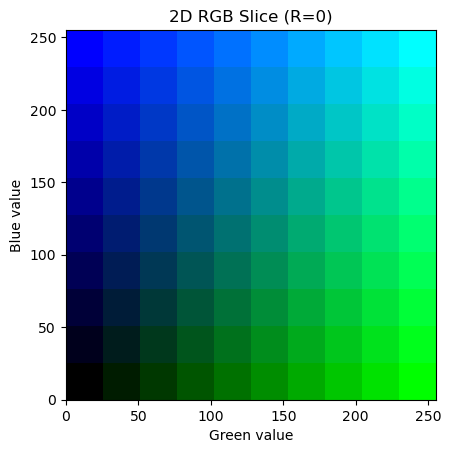

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Number of steps in each dimension (green, blue)
n_steps = 10  # change to 9 if you really only want 9 steps

# Create evenly spaced integer values from 0 to 255
values = np.linspace(0, 255, n_steps, dtype=int)

# Initialize an empty array for the 2D color grid
# Shape: (n_steps, n_steps, 3) for RGB channels
color_grid = np.zeros((n_steps, n_steps, 3), dtype=float)

# Fill the grid
# i will index blue, j will index green
for i, blue in enumerate(values):
    for j, green in enumerate(values):
        # Red channel = 0, green and blue scaled to [0,1] for matplotlib
        color_grid[i, j] = [0, green / 255.0, blue / 255.0]

plt.imshow(
    color_grid,
    origin='lower',       # so that the [0,0] index is at the bottom left
    extent=(0, 255, 0, 255)  # x-axis from 0 to 255 (green), y-axis from 0 to 255 (blue)
)
plt.xlabel("Green value")
plt.ylabel("Blue value")
plt.title("2D RGB Slice (R=0)")
plt.show()


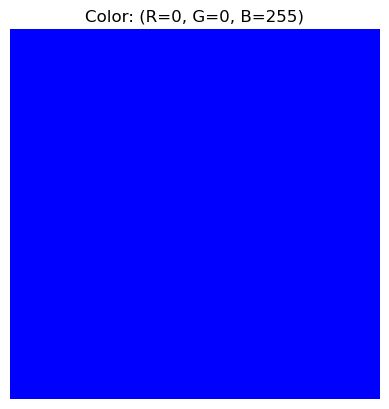

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Define the color [R=0, G=127, B=127]
color = [0, 0, 255]

# Create a small array (e.g., 50x50) filled with that color
height, width = 50, 50
color_array = np.zeros((height, width, 3), dtype=np.uint8)
color_array[:, :] = color  # Fill every pixel with (0,127,127)

# Display the color array
plt.imshow(color_array)
plt.axis('off')  # Hide axes if you want just the color
plt.title(f"Color: (R={color[0]}, G={color[1]}, B={color[2]})")
plt.show()
